# Stock Predictor RNN 

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict Apple's stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

## Step 1: Loading the data


In [1]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Text(0,0.5,'normalized series value')

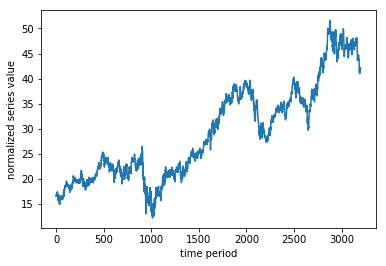

In [2]:
### load in the dataset
dataset = np.loadtxt('data/stocks_data.csv')
# store denormalize dataset in temp
temp = dataset

# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

Lets take a quick look at the (normalized) time series we'll be performing predictions on.

Text(0,0.5,'normalized series value')

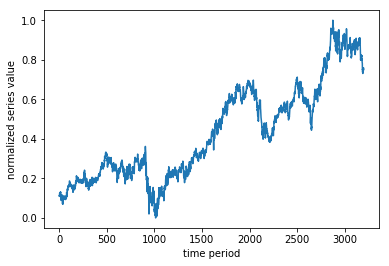

In [3]:
### normalize the dataset
mini = min(dataset)
maxi = max(dataset)
dataset = (dataset-min(dataset))/(max(dataset)-min(dataset))

# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

## Step 2:  Cutting our time series into sequences

In [4]:
### The function below transforms the input series and window-size into a set of input/output pairs for our RNN model
def window_transform_series(series,window_size,predict_days):
    # containers for input/output pairs
    X = []
    y = []
        
    for i in range(window_size, len(series)+1-predict_days):
        temp = []
        X.append(series[i - window_size:i])
        for j in range(0,predict_days):
            temp.append(series[i+j])
        y.append(temp)    
      
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.array(y) 
    y.shape = (-1,predict_days)
    return X,y

In [5]:
# And now we can window the data using our windowing function
window_size = 10  # no. of days whose data are used for prediction
predict_days = 3  # no.of days for which stock is predicted
X,y = window_transform_series(series = dataset,window_size = window_size, predict_days = predict_days)

## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [6]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point 2/3 part for training and 1/3 part for testing

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))


In [7]:
print(X_train.shape)
print(X_test.shape)

(2126, 10, 1)
(1063, 10, 1)


# Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [8]:
# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# start with fixed random seed
np.random.seed(0)

# Build an RNN to perform regression on our time series input/output data
model = Sequential()
model.add(LSTM(5, input_shape=(window_size, 1)))
model.add(Dense(predict_days))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

/home/amey/anaconda3/envs/keras_tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


With our model built we are now ready to train the model below!

In [9]:
print(X_train.shape)
print(y_train.shape)

(2126, 10, 1)
(2126, 3)


In [10]:
model.fit(X_train, y_train, epochs=500, batch_size=64, verbose=1)

Epoch 1/500
2126/2126 [==============================] - 1s 290us/step - loss: 0.0570
Epoch 2/500
2126/2126 [==============================] - 0s 88us/step - loss: 0.0196
Epoch 3/500
2126/2126 [==============================] - 0s 96us/step - loss: 0.0080
Epoch 4/500
2126/2126 [==============================] - 0s 90us/step - loss: 0.0029
Epoch 5/500
2126/2126 [==============================] - 0s 88us/step - loss: 7.9529e-04
Epoch 6/500
2126/2126 [==============================] - 0s 90us/step - loss: 4.7964e-04
Epoch 7/500
2126/2126 [==============================] - 0s 93us/step - loss: 4.4551e-04
Epoch 8/500
2126/2126 [==============================] - 0s 93us/step - loss: 4.4402e-04
Epoch 9/500
2126/2126 [==============================] - 0s 93us/step - loss: 4.2875e-04
Epoch 10/500
2126/2126 [==============================] - 0s 88us/step - loss: 4.2914e-04
Epoch 11/500
2126/2126 [==============================] - 0s 88us/step - loss: 4.2997e-04
Epoch 12/500
2126/2126 [==========

2126/2126 [==============================] - 0s 90us/step - loss: 3.0647e-04
Epoch 93/500
2126/2126 [==============================] - 0s 80us/step - loss: 3.0603e-04
Epoch 94/500
2126/2126 [==============================] - 0s 82us/step - loss: 3.0690e-04
Epoch 95/500
2126/2126 [==============================] - 0s 82us/step - loss: 3.0489e-04
Epoch 96/500
2126/2126 [==============================] - 0s 82us/step - loss: 3.0310e-04
Epoch 97/500
2126/2126 [==============================] - 0s 81us/step - loss: 3.0175e-04
Epoch 98/500
2126/2126 [==============================] - 0s 82us/step - loss: 2.9911e-04
Epoch 99/500
2126/2126 [==============================] - 0s 84us/step - loss: 3.0254e-04
Epoch 100/500
2126/2126 [==============================] - 0s 81us/step - loss: 3.0433e-04
Epoch 101/500
2126/2126 [==============================] - 0s 82us/step - loss: 2.9744e-04
Epoch 102/500
2126/2126 [==============================] - 0s 81us/step - loss: 2.9602e-04
Epoch 103/500
2126/2

2126/2126 [==============================] - 0s 115us/step - loss: 2.6555e-04
Epoch 182/500
2126/2126 [==============================] - 0s 100us/step - loss: 2.6343e-04
Epoch 183/500
2126/2126 [==============================] - 0s 92us/step - loss: 2.6014e-04
Epoch 184/500
2126/2126 [==============================] - 0s 93us/step - loss: 2.6094e-04
Epoch 185/500
2126/2126 [==============================] - 0s 88us/step - loss: 2.6502e-04
Epoch 186/500
2126/2126 [==============================] - 0s 92us/step - loss: 2.5889e-04
Epoch 187/500
2126/2126 [==============================] - 0s 94us/step - loss: 2.6165e-04
Epoch 188/500
2126/2126 [==============================] - 0s 92us/step - loss: 2.6332e-04
Epoch 189/500
2126/2126 [==============================] - 0s 89us/step - loss: 2.5863e-04
Epoch 190/500
2126/2126 [==============================] - 0s 94us/step - loss: 2.5913e-04
Epoch 191/500
2126/2126 [==============================] - 0s 95us/step - loss: 2.6251e-04
Epoch 192/5

2126/2126 [==============================] - 0s 83us/step - loss: 2.4713e-04
Epoch 271/500
2126/2126 [==============================] - 0s 79us/step - loss: 2.4753e-04
Epoch 272/500
2126/2126 [==============================] - 0s 104us/step - loss: 2.4855e-04
Epoch 273/500
2126/2126 [==============================] - 0s 83us/step - loss: 2.4520e-04
Epoch 274/500
2126/2126 [==============================] - 0s 76us/step - loss: 2.4898e-04
Epoch 275/500
2126/2126 [==============================] - 0s 74us/step - loss: 2.4678e-04
Epoch 276/500
2126/2126 [==============================] - 0s 76us/step - loss: 2.4688e-04
Epoch 277/500
2126/2126 [==============================] - 0s 80us/step - loss: 2.4917e-04
Epoch 278/500
2126/2126 [==============================] - 0s 79us/step - loss: 2.4782e-04
Epoch 279/500
2126/2126 [==============================] - 0s 81us/step - loss: 2.5031e-04
Epoch 280/500
2126/2126 [==============================] - 0s 79us/step - loss: 2.4314e-04
Epoch 281/50

2126/2126 [==============================] - 0s 115us/step - loss: 2.4212e-04
Epoch 361/500
2126/2126 [==============================] - 0s 100us/step - loss: 2.4284e-04
Epoch 362/500
2126/2126 [==============================] - 0s 102us/step - loss: 2.4067e-04
Epoch 363/500
2126/2126 [==============================] - 0s 88us/step - loss: 2.4290e-04
Epoch 364/500
2126/2126 [==============================] - 0s 91us/step - loss: 2.4295e-04
Epoch 365/500
2126/2126 [==============================] - 0s 89us/step - loss: 2.4121e-04
Epoch 366/500
2126/2126 [==============================] - 0s 93us/step - loss: 2.3868e-04
Epoch 367/500
2126/2126 [==============================] - 0s 140us/step - loss: 2.4277e-04
Epoch 368/500
2126/2126 [==============================] - 0s 138us/step - loss: 2.4068e-04
Epoch 369/500
2126/2126 [==============================] - 0s 94us/step - loss: 2.4251e-04
Epoch 370/500
2126/2126 [==============================] - 0s 88us/step - loss: 2.4005e-04
Epoch 37

2126/2126 [==============================] - 0s 93us/step - loss: 2.4142e-04
Epoch 451/500
2126/2126 [==============================] - 0s 83us/step - loss: 2.3702e-04
Epoch 452/500
2126/2126 [==============================] - 0s 94us/step - loss: 2.3980e-04
Epoch 453/500
2126/2126 [==============================] - 0s 83us/step - loss: 2.3970e-04
Epoch 454/500
2126/2126 [==============================] - 0s 84us/step - loss: 2.3866e-04
Epoch 455/500
2126/2126 [==============================] - 0s 84us/step - loss: 2.3998e-04
Epoch 456/500
2126/2126 [==============================] - 0s 86us/step - loss: 2.3909e-04
Epoch 457/500
2126/2126 [==============================] - 0s 85us/step - loss: 2.3919e-04
Epoch 458/500
2126/2126 [==============================] - 0s 104us/step - loss: 2.3937e-04
Epoch 459/500
2126/2126 [==============================] - 0s 89us/step - loss: 2.4010e-04
Epoch 460/500
2126/2126 [==============================] - 0s 83us/step - loss: 2.3998e-04
Epoch 461/50

# Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

In [11]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [12]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.0002327205097216934
testing error = 0.00036746152216784994


Activating the next cell plots the original data, as well as both predictions on the training and testing sets. 

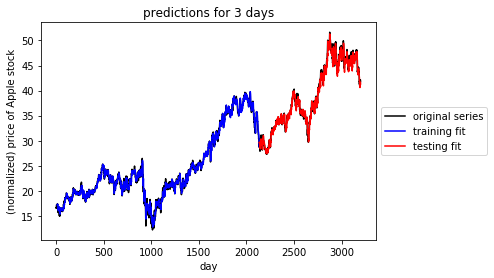

In [13]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
#plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
#plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
for i in range(predict_days):
    plt.figure(i+1)
    plt.plot(temp,color = 'k') 
    train_days = (np.array(np.reshape(train_predict[i:train_test_split:predict_days,],(-1,1))[:train_test_split]).shape)[0]-i
    test_days = (test_predict.shape)[0]+predict_days-1-i
    #test_days = (np.array(np.reshape(test_predict[i::predict_days,],(-1,1))[i:]).shape)[0]-i
    plt.plot(np.arange(window_size+i,window_size+(np.array(np.reshape(train_predict[i:train_test_split:predict_days],(-1,1))[:train_test_split]).shape)[0],1),np.reshape(train_predict[i:train_test_split:predict_days]*(maxi-mini)+mini,(-1,1))[:train_days],color = 'b')
    plt.plot(np.arange(split_pt+i,split_pt+i+(np.array(np.reshape(test_predict[i::predict_days,],(-1,1))[:test_days]).shape)[0],1),np.reshape(test_predict[i::predict_days,]*(maxi-mini)+mini,(-1,1))[:test_days],color = 'r')
    #plt.plot(np.arange(split_pt+i,split_pt + ((test_predict.shape)[0]),1),((np.reshape(test_predict[i::predict_days],(-1,1)))[:test_predict.shape[0]+1]),color = 'r')
    
    # pretty up graph
    plt.title("predictions for "+ str(predict_days)+" days")
    plt.xlabel('day')
    plt.ylabel('(normalized) price of Apple stock')
    plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    break
